In [1]:
import os 
from datetime import datetime
import ubiops
from dotenv import load_dotenv

import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
import utils


In [2]:
# Enter your API token here
load_dotenv(".env")

client = ubiops.ApiClient(ubiops.Configuration(
	host="https://api.ubiops.com/v2.1",
	api_key={"Authorization": os.environ["TOKEN_RAYCAST_USER"]})
)

api = ubiops.CoreApi(client)


In [5]:
# specify the reference datetime
ref_datetime = datetime.strptime("2024-06-20 09:30:00", "%Y-%m-%d %H:%M:%S")

# request
utils.raycast_data_by_query(token=os.environ["TOKEN_RAYCAST_USER"], ref_datetime=ref_datetime)
ds = xr.open_dataset(f"irradiance_{ref_datetime.strftime('%Y%m%dT%H%M%S')}.nc", engine="netcdf4")

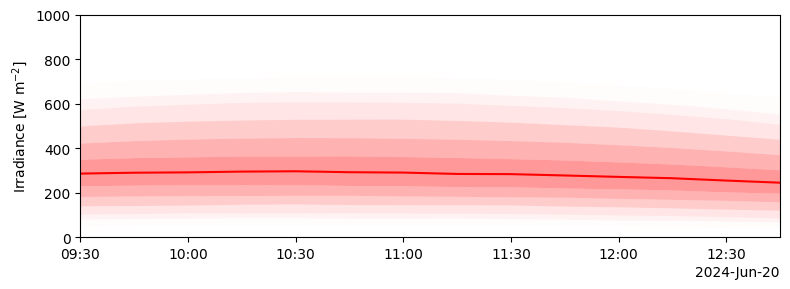

In [6]:
# specify location
x = 5.177       
y = 52.101

fig, ax = plt.subplots(1,1,figsize=(8,3))

# Get the alpha values for the PIs
alphas = ds['quantile'].values[::-1][:6]

# Get the data for a specific location
location_data = ds.sel(x=x, y=y, method='nearest')

# Loop over the quantiles and plot the PIs
for q in range(6):
    q_up = ds['quantile'][q].values
    q_down = ds['quantile'][q+1].values

    alpha = alphas[q]

    ax.fill_between(
        x=ds.time.values,
        y1=location_data.sel(quantile=q_up)['irradiance'].values,
        y2=location_data.sel(quantile=q_down)['irradiance'].values,
        color='red',
        alpha=alpha,
        linewidth=0
    )

    q_up = ds['quantile'][q+6].values
    q_down = ds['quantile'][q+6+1].values

    alpha = alphas[::-1][q]

    ax.fill_between(
        x=ds.time.values,
        y1=location_data.sel(quantile=q_up)['irradiance'].values,
        y2=location_data.sel(quantile=q_down)['irradiance'].values,
        color='red',
        alpha=alpha,
        linewidth=0
    )

# Plot the median
ax.plot(
        ds.time.values,
        location_data.sel(quantile=0.5)['irradiance'].values,
        color='red',
    )

# Format the axes and labels
ax.set_ylim(0, 1000)
ax.set_xlim(ds.time.values[0], ds.time.values[-1])
ax.set_ylabel('Irradiance [W m$^{-2}$]')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
